# Machine Learning 3: Principle Components Analysis (PCA) & Logistic Regression 

## Submission by: Mark Preston

This week's assignment will focus on using both Principle Components Analysis (PCA) & multi-class logistic regression using government health care data. Specifically, this data set provides general information on active nursing homes, which includes columns for the number of certified beds, quality measure scores, and staffing, among other variables. All of the numeric fields are filled using a 5-star ranking system with 5 being the best. Each row represents an individual nursing  home. With that in mind, the unit of analysis here is nursing homes, which have a variety of rating metrics. 

### Data Processing: 

Kicking off the exercise, I've loaded in the data and imported `pandas` as well. The initial set has 15,617 individual nursing homes, each with 78 variables associated with it.

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

nursing_homes = pd.read_csv("ProviderInfo.csv", low_memory=False)

print("The initial nursing home data has", 
      nursing_homes.shape[0], "rows and", 
      nursing_homes.shape[1],  "columns")

The initial nursing home data has 15617 rows and 78 columns


Starting the data cleaning, I've dropped all the non-numeric columns using `select_dtypes`. On top of this, I've also dropped Phone and County SSA, which happen to be numeric, but are not needed for the analysis. Following this, the set has 28 remaining columns.

In [3]:
nursing_homes = nursing_homes.select_dtypes(include=["number"])

nursing_homes = nursing_homes.drop(["COUNTY_SSA", "PHONE"], axis=1)

print("The data with only numeric columns and 2 other drops now has", 
      nursing_homes.shape[0], "rows and", 
      nursing_homes.shape[1])

The data with only numeric columns and 2 other drops now has 15617 rows and 28


Other cleaning tasks need to be performed as well. For example, every column in the set has at least one null value, so these will have to be dropped.

In [4]:
pd.DataFrame({"is_null_count": nursing_homes.isnull().sum()})

,is_null_count
ZIP,1
BEDCERT,1
RESTOT,512
OVERALL_RATING,181
SURVEY_RATING,181
QUALITY_RATING,214
STAFFING_RATING,349
RN_STAFFING_RATING,349
AIDHRD,947
VOCHRD,947


To get rid of these records, I've used the `dropna` function. Following this, 14,557 nursing home records remain, which matches the assignment specifications.

In [5]:
nursing_clean = nursing_homes.dropna()

print("The cleaned data now has", 
      nursing_clean.shape[0], "rows and", 
      nursing_clean.shape[1], "columns")

The cleaned data now has 14557 rows and 28 columns


Following this, the modelling set is ready to go. With this, I've used the set to develop a train and test split using 80/20 proportions. I've verified the correct dimensions below.

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

predictors = nursing_clean.drop(columns=["OVERALL_RATING"], axis=1)

outcome = nursing_clean[["OVERALL_RATING"]]

X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, random_state=1017, test_size=.2)

print(
"Training set rows:", X_train.shape[0], "which is", 
    np.round(X_train.shape[0] / nursing_clean.shape[0] * 100), 
    "percent of total records"
)

print(
"Test set rows:", X_test.shape[0], "which is", 
    np.round(X_test.shape[0] / nursing_clean.shape[0] * 100),
    "percent of total records"
)

Training set rows: 11645 which is 80.0 percent of total records
Test set rows: 2912 which is 20.0 percent of total records


With the set split, I've also scaled both sets using a mixture of the Sci-Kit Learn `StandardScaler` and a for loop to apply the appropriate mean and variance to each column so the values are converted to z-scores. This operation completes the data cleaning work and sets up the modelling phase.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=list(predictors.head(0)))
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.head(0)))

X_test_scaled[["ZIP", "SURVEY_RATING", "QUALITY_RATING", "STAFFING_RATING", "RN_STAFFING_RATING"]].head()

,ZIP,SURVEY_RATING,QUALITY_RATING,STAFFING_RATING,RN_STAFFING_RATING
0,1.129530,-1.414497,0.822147,0.694693,1.276307
1,-0.664537,0.915212,0.822147,-0.133237,-1.077729
2,-0.211445,0.915212,0.822147,0.694693,0.491629
3,1.499774,-0.637928,0.822147,-0.961166,-1.862407
4,0.943549,1.691782,0.822147,-1.789095,-1.862407


### Model 1: Logistic Regression

Before getting into the modelling, I wanted to understand the class balance. Of interest, I wanted to see how many nursing homes were rated between 1 and 5. The data frame below highlights that a 5-rating is the most common score (which seems like a very positive thing for nursing homes!). In fact, the rating counts are nearly cascading, with the exception of 2 and 3 switching spots. My intuition here is that 5-star ratings should be the highest accuracy given the abundance of cases. 

In [8]:
pd.DataFrame(y_test["OVERALL_RATING"].value_counts())

,OVERALL_RATING
5.0,831
4.0,664
2.0,574
3.0,501
1.0,342


With the class proportions reviewed, the first model I've developed here is a logistic regression model with all 27 variables. The `score` function, which provides the classification model's mean accuracy, shows .686. For a multi-class prediction on a "real world" set with imbalanced levels, this seems like a reasonable starting point. It also highlights that there is likely some classes where the predictions are not very good. The first 10 rows comparing the actual values and predictions show some congruency though with 3-star ratings being the only misses. 

In [9]:
from sklearn.linear_model import LogisticRegression

rating_log = LogisticRegression()

rating_log.fit(X_train_scaled, y_train["OVERALL_RATING"].values.ravel())

y_test["rating_predict"] = rating_log.predict(X_test_scaled)

test_mean_score = rating_log.score(X=X_test_scaled, y=y_test["OVERALL_RATING"]).round(3)

print("Test mean accuracy:", test_mean_score)
print("First 10 rows printed below:")

y_test.head(10)

Test mean accuracy: 0.686
First 10 rows printed below:


,OVERALL_RATING,rating_predict
1393,2.0,2.0
2211,5.0,5.0
10618,5.0,5.0
1021,3.0,2.0
14848,5.0,5.0
3208,3.0,2.0
14289,1.0,1.0
6803,2.0,2.0
3072,3.0,4.0
11696,5.0,5.0


The initial 3-start ratings I pointed out as being misclassified were indicative of accuracy issues with that class. The confusion matrix below (actuals as rows, predictions as columns) shows that only 65 of 501 cases were correctly classified, which stands out as the worst performance here. 5 seems to have the best accuracy while the other classes seem fairly even, with the exception of 3 as noted above.

In [10]:
from sklearn.metrics import confusion_matrix

rating_cm = pd.DataFrame(confusion_matrix(y_true=y_test["OVERALL_RATING"], y_pred=y_test["rating_predict"]), 
                         index= np.array([1,2,3,4,5]), 
                         columns= np.array([1,2,3,4,5]))

rating_cm

,1,2,3,4,5
1,264,78,0,0,0
2,68,418,78,10,0
3,0,202,65,234,0
4,0,98,2,442,122
5,0,0,0,21,810


Visualizing the confusion matrix re-emphasizes the accuracy metrics. For example, the row for 3 has a mix of dark purple colours highlighting that the predictions here are spread out across several incorrect classes. In contrast, the row for 5 is almost all black with the overwhelming number of predictions being correct. The ideal colour mix here would be black cells throughout, save for the diagonals. This is fairly close in reality, though the 3 class really throws off the model accuracy.

Text(0.5,1,'Confusion Matrix for Nursing Home Rating Predictions: Classifier does well at 5 / 5 predictions')

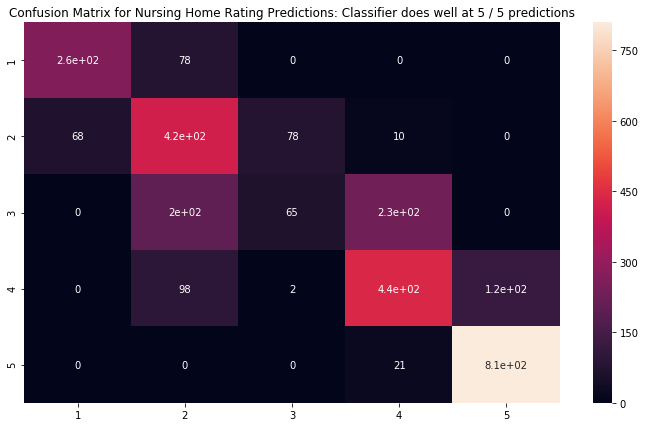

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 7))

sns.heatmap(rating_cm, 
            annot=True).set_title("Confusion Matrix for Nursing Home Rating Predictions: Classifier does well at 5 / 5 predictions")

#### Based on the confusion matrix and classification report, do any of the classes get predicted exceptionally poorly?

Before interpreting the report, it's important to go over the definition for each metric:

$Precision = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$

$Recall = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

$F1 = 2 * \frac{\text{Precision * Recall}}{\text{Precision + Recall}}$

The classification report bolsters the cases that the predictions for 3-star ratings are the poorest amongst all classes. It has the lowest precision, recall, and F1-score. Given this class has the worst accuracy metrics, I think these are exceptionally poor predictions.

My guess here would be because it's the most ill-defined, middling class, the variables defining it are much less clear than an extreme rating, like 5. I think this intuition is strengthened by the fact that most of the misclassified cases here are split between 2 and 4, which are more extreme. This highlights that the classification differences between a 2 or 4 rating and three is possibly marginal. While this isn't definitive, I think this seems plausible given the report and confusion matrix.

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test["OVERALL_RATING"], y_test["rating_predict"]))

class_1_F1 = 2 * ((.8 * .77) / (.8 + .77))

print("Manual F-1 for class 1:", str(round(class_1_F1, 2)), "which matches the report score")

             precision    recall  f1-score   support

        1.0       0.80      0.77      0.78       342
        2.0       0.53      0.73      0.61       574
        3.0       0.45      0.13      0.20       501
        4.0       0.63      0.67      0.64       664
        5.0       0.87      0.97      0.92       831

avg / total       0.66      0.69      0.66      2912

Manual F-1 for class 1: 0.78 which matches the report score


#### Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

To gather the training set classifications, I've used predict on the original fit using the scaled training set. As with before, I've included the mean accuracy here alongside the test value. There's about an 1.3% drop off in mean accuracy from train to test indicating some overfitting.

In [13]:
y_train["rating_fitted"] = rating_log.predict(X_train_scaled)

train_mean_score = rating_log.score(X=X_train_scaled, y=y_train["OVERALL_RATING"]).round(3)

print("Training mean accuracy:", train_mean_score)
print("Test mean accuracy:", test_mean_score)

print("First 10 rows printed below:")

y_train.head(10)

Training mean accuracy: 0.699
Test mean accuracy: 0.686
First 10 rows printed below:


,OVERALL_RATING,rating_fitted
8958,1.0,1.0
7779,4.0,4.0
8403,5.0,5.0
6120,4.0,4.0
7981,2.0,1.0
11756,1.0,1.0
12327,2.0,2.0
10991,2.0,3.0
6275,3.0,4.0
4682,1.0,2.0


The training matrix again highlights that there might be some overfitting. For example, the classifications for 1 appear much stronger.

In [14]:
train_rating_cm = pd.DataFrame(confusion_matrix(y_true=y_train["OVERALL_RATING"], y_pred=y_train["rating_fitted"]), 
                               index= np.array([1,2,3,4,5]), 
                               columns= np.array([1,2,3,4,5]))

train_rating_cm

,1,2,3,4,5
1,1063,292,2,0,0
2,241,1718,312,53,0
3,1,755,224,912,0
4,0,411,14,1805,424
5,0,0,0,84,3334


Finally, the classification report shows a drop between the accuracy metrics from train to test, which is a sign of overfitting. However, each average per metrics only drops by .1, so it isn't a huge issue.

In [15]:
print(classification_report(y_train["OVERALL_RATING"], y_train["rating_fitted"]))

             precision    recall  f1-score   support

        1.0       0.81      0.78      0.80      1357
        2.0       0.54      0.74      0.62      2324
        3.0       0.41      0.12      0.18      1892
        4.0       0.63      0.68      0.66      2654
        5.0       0.89      0.98      0.93      3418

avg / total       0.67      0.70      0.67     11645



#### Print out an example of the predicted probability

Below, instead of the actual class predictions, I've included the probabilities for belonging to certain classes. For example, there's about 70% chance of the nursing home in row 1 (index 0) having a 2-star rating. In this way, the confidence of each classification can be gauged.

In [16]:
pd.DataFrame(rating_log.predict_proba(X_test_scaled), columns=np.array([1,2,3,4,5])).head()

,1,2,3,4,5
0,7.144949e-03,0.694841,0.166608,0.131308,0.000099
1,3.988809e-07,0.016271,0.082154,0.202108,0.699466
2,5.007430e-08,0.011217,0.084588,0.242368,0.661827
3,9.525500e-03,0.473684,0.281362,0.235376,0.000053
4,3.907084e-07,0.004835,0.088969,0.192382,0.713813


### Model 2: PCA (n_components = 2) + Logistic Regression

As with last week, this section calls for model building and evaluation with small variants between iterations. With this in mind, I've developed a function to streamline the process and reduce code. `pca_logistic` only takes one argument, which specifies how many components that pca logistic model should use. It then returns the necessary evaluation metrics for both train and test so the model can be reviewed. With the function created, I've developed the first model by specifying it should include 2 principle components.

In [18]:
from sklearn.decomposition import PCA

def pca_logistic(n_components):
    #pca steps
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    exp_var = pd.DataFrame({"variance_exp_ratio": pca.explained_variance_ratio_}).round(3)
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled)) 
    X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))
    
    #pca logistic regression model
    rating_log.fit(X_train_pca, y_train["OVERALL_RATING"].values.ravel())
    
    pca_test_preds = rating_log.predict(X_test_pca)
    test_mean_score = rating_log.score(X=X_test_pca, y=y_test["OVERALL_RATING"]).round(3)
    
    pca_train_preds = rating_log.predict(X_train_pca)
    train_mean_score = rating_log.score(X=X_train_pca, y=y_train["OVERALL_RATING"]).round(3)
    
    #pca confusion matrices
    test_pca_cm = pd.DataFrame(confusion_matrix(y_true=y_test["OVERALL_RATING"], y_pred=pca_test_preds), 
                          index= np.array([1,2,3,4,5]), 
                          columns= np.array([1,2,3,4,5]))
    
    train_pca_cm = pd.DataFrame(confusion_matrix(y_true=y_train["OVERALL_RATING"], y_pred=pca_train_preds), 
                          index= np.array([1,2,3,4,5]), 
                          columns= np.array([1,2,3,4,5]))
    
    
    #pca classification reports
    test_pca_class_report = classification_report(y_test["OVERALL_RATING"], pca_test_preds)
    train_pca_class_report = classification_report(y_train["OVERALL_RATING"], pca_train_preds)
    
    output = {"variance_explained": exp_var,
              "test_mean": test_mean_score,
              "train_mean": train_mean_score,
              "test_cm": test_pca_cm,
              "train_cm": train_pca_cm,
              "test_report": test_pca_class_report,
              "train_report": train_pca_class_report,
              }
    
    
    return(output)

pca_logistic_n2 = pca_logistic(n_components=2)

The first metric I'm looking at here is the mean accuracy score for train and test. These show a precipitous decline from the initial full model. The train and test split is pretty much even so there isn't really overfitting here, though this will be checked further going forward.

In [19]:
print("PCA (n = 2) logistic model  train mean:", pca_logistic_n2["train_mean"])
print("PCA (n = 2) logistic model test mean:", pca_logistic_n2["test_mean"])

PCA (n = 2) logistic model  train mean: 0.383
PCA (n = 2) logistic model test mean: 0.381


The confusion matrices below show the same poor fit. One of the biggest accuracy drops is seen in class 5, which was the strongest in the initial model. Perhaps more shocking though is not a single correct class 3 prediction in test.

In [20]:
pca_logistic_n2["train_cm"]

,1,2,3,4,5
1,539,637,6,31,144
2,397,961,5,82,879
3,159,743,3,91,896
4,95,617,0,97,1845
5,37,435,4,87,2855


In [21]:
pca_logistic_n2["test_cm"]

,1,2,3,4,5
1,120,178,1,10,33
2,96,263,0,19,196
3,37,193,0,18,253
4,24,131,1,21,487
5,7,97,0,21,706


Both reports continue to highlight the model's poor prediction performance. Overall though, there doesn't seem to be much overfitting despite some small variance between train and test accuracy metrics.

In [22]:
print(pca_logistic_n2["train_report"])

             precision    recall  f1-score   support

        1.0       0.44      0.40      0.42      1357
        2.0       0.28      0.41      0.34      2324
        3.0       0.17      0.00      0.00      1892
        4.0       0.25      0.04      0.06      2654
        5.0       0.43      0.84      0.57      3418

avg / total       0.32      0.38      0.30     11645



In [23]:
print(pca_logistic_n2["test_report"])

             precision    recall  f1-score   support

        1.0       0.42      0.35      0.38       342
        2.0       0.31      0.46      0.37       574
        3.0       0.00      0.00      0.00       501
        4.0       0.24      0.03      0.06       664
        5.0       0.42      0.85      0.56       831

avg / total       0.28      0.38      0.29      2912



#### How well does this model perform relative to Model 1? Explain why there is a shift in performance.

This model performs significantly worse than the full variable logistic regression. The performance shift is linked to reducing the 27 variables into two principle components, which inherently reduces the amount of information captured by the new set. As seen below, these new variables only capture a fraction of the variance the full set does. 

In [24]:
two_pca_var = pca_logistic_n2["variance_explained"]
two_pca_var = two_pca_var["variance_exp_ratio"].sum().round(4)

print("Percent variance captured by two principle components:", two_pca_var)

Percent variance captured by two principle components: 0.383


Using these variance explanations is how the number of components is loosely picked. The visualization below highlights this as every principle component's variance explanation is plotted. Using this scree plot, the sweet spot is finding the component where the variance explanation begins to even out. In this case, it's around 16 but, could probably go as high as 19.  

Text(0.5,1,'PCA Screeplot for Nursing Home Data \n Variance explanation evens out around 16 components')

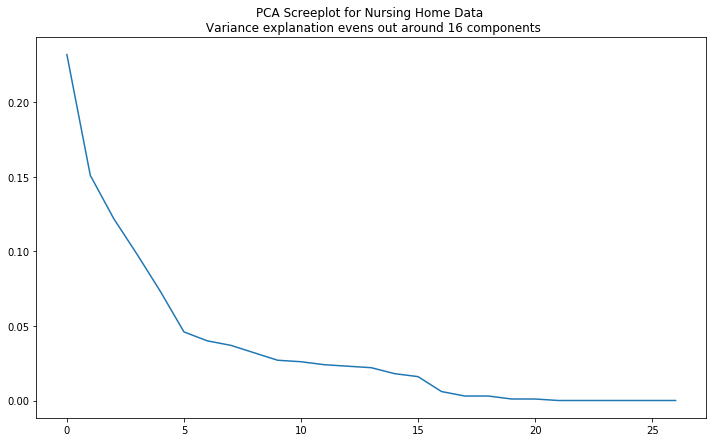

In [26]:
pca_logistic_n27 = pca_logistic(n_components=27)

%matplotlib inline
plt.figure(figsize = (12, 7))
plt.plot(pca_logistic_n27["variance_explained"])
plt.title("PCA Screeplot for Nursing Home Data \n Variance explanation evens out around 16 components")

### Model 3: PCA (n_components = 16) + Logistic Regression

Using the scree plot, it appears 16 principle components is a reasonable number to construct a model with. It also happens to be the next modelling choice as per the assignment. I've followed the same process a the two component model below. 

In [40]:
pca_logistic_n16 = pca_logistic(n_components=16)

The first metric I'm looking at here again is the mean accuracy score for train and test. These are almost in line with the original metrics, save for small differences. As with before, there might be minor overfitting but, they look quite close.

In [41]:
print("PCA (n = 16) logistic model  train mean:", pca_logistic_n16["train_mean"])
print("Training mean accuracy with 27 variables:", train_mean_score)
print("PCA (n = 16) logistic model test mean:", pca_logistic_n16["test_mean"])
print("Test mean accuracy with 27 variables:", test_mean_score)

PCA (n = 16) logistic model  train mean: 0.696
Training mean accuracy with 27 variables: 0.699
PCA (n = 16) logistic model test mean: 0.677
Test mean accuracy with 27 variables: 0.686


The confusion matrices below show a similar fit to the original model as well.

In [42]:
pca_logistic_n16["train_cm"]

,1,2,3,4,5
1,1061,295,1,0,0
2,247,1715,298,64,0
3,1,757,219,915,0
4,0,406,7,1776,465
5,0,0,0,82,3336


In [43]:
pca_logistic_n16["test_cm"]

,1,2,3,4,5
1,262,80,0,0,0
2,81,410,72,11,0
3,0,204,63,234,0
4,0,102,2,423,137
5,0,0,0,18,813


Both reports also align with the original model. In addition, the evaluation metrics don't drop too much between train and test so while there might be minor overfitting, it's relatively small.

In [44]:
print(pca_logistic_n16["train_report"])

             precision    recall  f1-score   support

        1.0       0.81      0.78      0.80      1357
        2.0       0.54      0.74      0.62      2324
        3.0       0.42      0.12      0.18      1892
        4.0       0.63      0.67      0.65      2654
        5.0       0.88      0.98      0.92      3418

avg / total       0.67      0.70      0.67     11645



In [45]:
print(pca_logistic_n16["test_report"])

             precision    recall  f1-score   support

        1.0       0.76      0.77      0.76       342
        2.0       0.52      0.71      0.60       574
        3.0       0.46      0.13      0.20       501
        4.0       0.62      0.64      0.63       664
        5.0       0.86      0.98      0.91       831

avg / total       0.66      0.68      0.65      2912



### Conceptual Questions

#### In order to better understand what is happening in Model 2 & Model 3, re-run PCA without specifying a number of components. Plot out the cumulative explained variance ratio vs number of components for the original scaled data. Describe what the plot is showing as well as what the cumulative explained variance tells us about our data.

I conducted this analysis as part of the assignment because I felt it added a clear logic between moving from 2 to 16 components. The plot below is shown again for consistency though. It shows how each principle component, which are eigenvalues stemming from the matrix decomposition, slowly reduces in variance explanation. The first component here represents about 23% of the set's total variance. Beyond that, each component represents slightly less. The first eigenvalue representing about 23% is indicative of a set that doesn't have a high degree of multicollinearity. Data that is very highly correlated usually makes for a first principle component that captures a large amount of variance from the set. Each principle component could be analyzed further to understand what variance is being captured using the eigenvector matrix, which are also known as factor loadings. Here though, it's probably enough to say that the variables seems reasonably spread across the principle components with a few eigenvalues containing most of the variance explanation but, up to around 16 being useful for analysis.  

Text(0.5,1,'PCA Screeplot for Nursing Home Data \n Variance explanation evens out around 16 components')

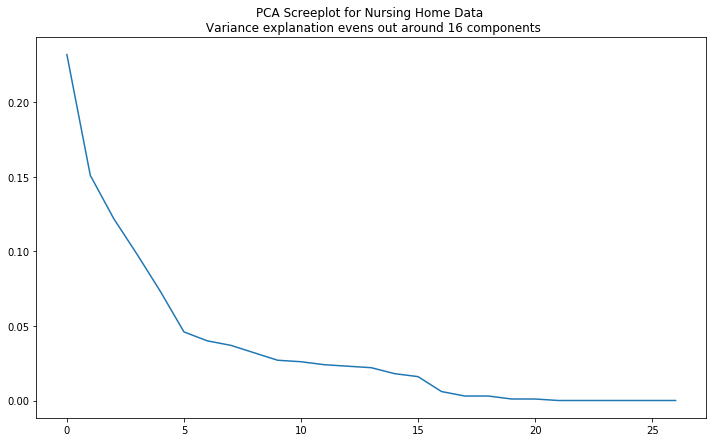

In [47]:
plt.figure(figsize = (12, 7))
plt.plot(pca_logistic_n27["variance_explained"])
plt.title("PCA Screeplot for Nursing Home Data \n Variance explanation evens out around 16 components")

Building on the previous point, I've included the correlation matrix here. While there are some strong correlations, there doesn't appear to be any major multicollinearity, which helps explain why the first few principle components don't capture as much variance. Essentially, the variable's explanatory power is spread across 16 factors, at which point the variance explanation plateaus.

Text(0.5,1,'Confusion Matrix for Nursing Home Rating Variables')

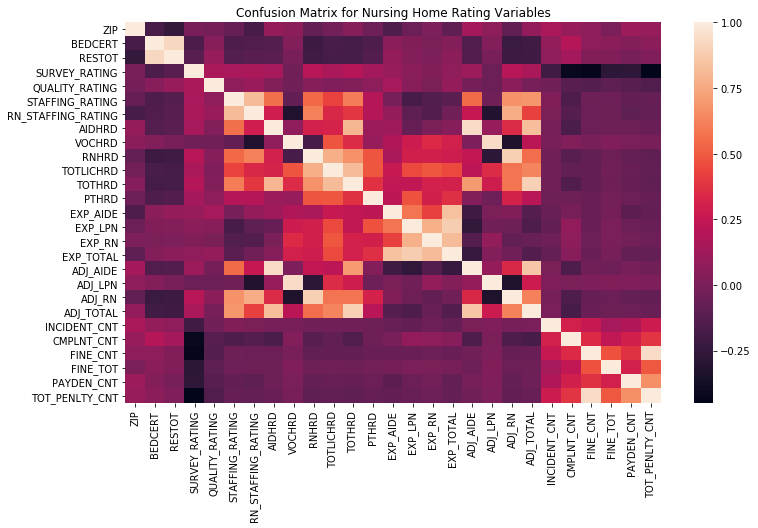

In [48]:
var_corr = X_train_scaled.corr()

plt.figure(figsize = (12, 7))


sns.heatmap(var_corr, 
            xticklabels=var_corr.columns.values,
            yticklabels=var_corr.columns.values).set_title("Confusion Matrix for Nursing Home Rating Variables")

#### Between Model 2 and Model 3, which performed the best? Explain why this is.

This question connects nicely from the previous explanation of how much variance is explained between the different principle components. The performance comes down to how much variance is represented by two versus sixteen principle components. As seen below, two only captures about 38% of the set variance while 16 captures about 99%. Given this, it's no surprise that the sixteen component model 3 shows such superior performance since it's nearly equivalent to the original set from a variance explanation perspective. Indeed, the evaluation metrics highlight it being nearly equal to the full variable set, which makes sense having seen how much variance these components explain. This also furthers the case that there are numerous predictors amongst the original 27 that do no provide a great deal of explanatory power in the model and therefore, could be dropped. This could be further explored with a formal factor analysis, among other model refinement tactics.

In [50]:
sixteen_pca_var = pca_logistic_n16["variance_explained"]
sixteen_pca_var = sixteen_pca_var["variance_exp_ratio"].sum().round(4)

print("Percent variance captured by two principle components:", two_pca_var)
print("Percent variance captured by sixteen principle components:", sixteen_pca_var)

Percent variance captured by two principle components: 0.383
Percent variance captured by sixteen principle components: 0.987


#### Assuming you are working with a company on a modeling project with a massive data set, what would be some of the benefits of utilizing PCA?  Provide counterarguments for using the method as well.

The case for principle components analysis lies in the computational savings stemming from dimensional reduction. As displayed above, the sixteen component model performs more or less equally to the full 27 variable set. This saves 9 variables from being included in the model, which inherently reduces complexity and saves on computational costs. A set with higher multicollinearity would see this effect even more. Overall, this approach doesn't necessarily sacrifice performance while providing less complex models. Another advantage would be using the approach for factor analysis and visualization. Using the factor loadings, each principle component can be assessed and named. For example, the first component might represent information on nurse ratings. In this way, the resulting factor score columns don't lose meaning during dimensional reduction. Taking this a step further, complex, multidimensional sets can be simplified to two or three components and visualized so some underlying pattern in the set can be explored. 

The obvious trade off here is interpretability and information loss. Starting with the factor scores, the columns often lose any intrinsic interpretability once they have been converted. If the factor loadings do not provide clear naming conventions, any inferential modelling work is greatly hindered. If the project requires clear explanation of what might be driving results, sometimes PCA falls short. Probably more importantly, PCA inherently leads to information loss from the data set. I've documented that included only a few principle components in a model reduces model performance. Even with the sixteen model, some variance is being excluded that could boost performance. There is a trade-off being computational complexity and results using PCA. Additionally, the method doesn't work well on every data. If there isn't reasonable multicollinearity to start with, the factor scores will essentially be the original columns scrambled. In the case here, there was enough to make it successful but, that's isn't guaranteed. Building on this point, the set itself has to be comprised of only numeric variables. Technically, categorical columns can be converted to dummies but, this approahc belies the linear algebra underpinnings and is generally not great practice. All considered, there are some downfalls to PCA so the use case has to be carefully reviewed.

#### Sklearn offers a variety of methods to solve a multi-class logistic regression problem. One option is the "one-vs-the-rest" (also known as "one-vs-all" method). Explain in detail what this process does.

I mentioned this before but, the one-vs-all method constructs probabilities of an entry belonging to a certain class. More specifically though, the method constructs a series of binary classifiers for each class in the multi-class arrangement. In the work here, a specific nursing home rating is identified between 1 and 5, so there are 5 binary classifiers, or one per rating.This means that during the model training, each nursing home is being assessed different ways. For example, the first set of probabilities provides some level of confidence for the question of whether the home is, or is not, rated 1. This procedure continues until there is a probability for each class at which point, the highest confidence becomes the rating prediction.

#### Each of the three models utilized logistic regression. The Hands-On ML book describes the logistic function (sometimes called the sigmoid function) in detail. Using Equation 4-14, plot out the logistic function & describe why it is useful in classification problems of the nature covered in this homework assignment.

A logistic regression model computes the weighted sum of features and then uses a link function to transform the values into a number between 0 and 1. These correspond to probabilities of being in a certain class when used for prediction. This is why logistic regression is so useful for classification problems: it provides easy to understand probabilities that can be converted to classes using some decision boundary or threshold. Traditionally, if the probability is greater than or equal to .5, it becomes a positive class (1) and otherwise a negative class (0). This is formalized below: 

$$\hat{p} = {\text{predicted probability of belonging to a class}}$$

$$\hat{p} =
\begin{cases}
0,  & \text{if $x$ < 0.5} \\
1, & \text{if $x$ >= 0.5}
\end{cases}$$

 The sigmoid function below highlights this where the observations above and below the green line are classified differently. Further, in this example, the x-axis values for that prediction can be ascertained as well adding further interpretability. For all these reasons, logistic regression makes an excellent and interpretable classifier choice.

Text(3,0.6,'$\\sigma(t)=\\frac{1}{1+e^{-t}}$')

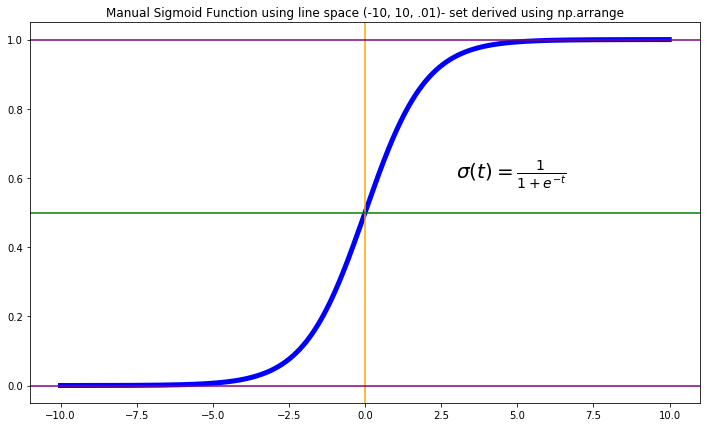

In [6]:
def sigmoid_function(t):
    return (1 / (1 + np.exp(-t)))

t =  np.arange(-10, 10, 0.01)
plt.figure(figsize = (12, 7))

plt.plot(t, sigmoid_function(t), color = "blue", linewidth=5)
plt.axvline(x = 0, color="orange")
plt.axhline(y= 0, color="purple")
plt.axhline(y =.5, color="green")
plt.axhline(y = 1, color="purple")
plt.title("Manual Sigmoid Function using line space (-10, 10, .01)- set derived using np.arrange")
plt.text(3, 0.6, r"$\sigma(t)=\frac{1}{1+e^{-t}}$", fontsize = 20)

In [471]:
import os
os.getcwd()

'C:\\Users\\Mark\\Machine Learning 3'